# Cloud Classification: Class Activation Maps
---

## Import Libraries

In [2]:
%matplotlib inline

In [1]:
from fastai.vision import *

In [3]:
np.random.seed(42)
DATA = Path("../data/")
CLASSES = ['cirrus', 'cumulus', 'stratus']

## Load Data

In [6]:
tfms = get_transforms(do_flip=True, flip_vert=False,max_zoom=1.5,
                      max_lighting=0.4, max_warp=0.3,
                      p_affine=1.0, p_lighting=1.0)

In [7]:
df = pd.read_csv(DATA/'cleaned.csv', header='infer')

In [8]:
df.head()

,name,label
0,cirrus/00000099.jpg,cirrus
1,cirrus/00000069.jpg,cirrus
2,cirrus/00000001.jpg,cirrus
3,cirrus/00000074.jpg,cirrus
4,cirrus/00000022.jpg,cirrus


In [9]:
old_data = ImageDataBunch.from_folder(DATA, train=".", valid_pct=0.2, size=224, bs=10)

In [10]:
data = (ImageList.from_csv(DATA, csv_name='cleaned.csv', header='infer')
           .split_by_rand_pct(valid_pct=0.0)
           .label_from_df(cols='label')
           .transform(tfms, size=224)
           .databunch(bs=10))

In [11]:
len(data.valid_ds),len(old_data.valid_ds) 

(1, 57)

In [12]:
data.valid_dl = old_data.valid_dl

In [13]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (229 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cirrus,cirrus,cirrus,cirrus,cirrus
Path: ../data;

Valid: LabelList (57 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cirrus,cumulus,stratus,cirrus,cumulus
Path: ../data;

Test: None

## Data Visualization

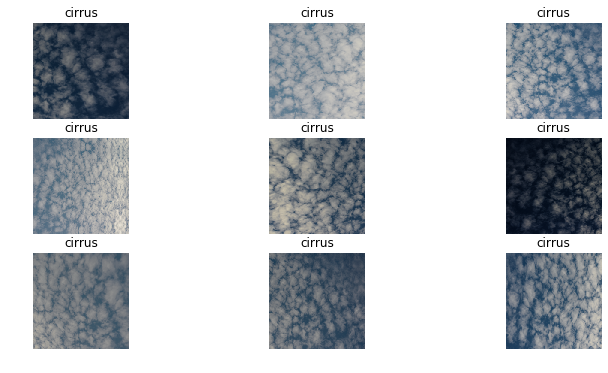

In [14]:
def _plot(r, c, ax):
    x,y = data.train_ds[10]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3)

## Load Model

In [15]:
learner = cnn_learner(data, models.resnet34).load('stage-6');

## Convolution Kernel

### Grab one data item

In [248]:
xb,yb = data.valid_ds[4]

In [249]:
x,_ = data.one_item(xb)
x.shape

torch.Size([1, 3, 224, 224])

cumulus


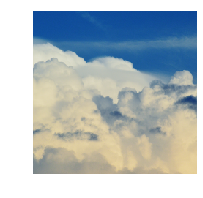

In [250]:
x_img = Image(data.denorm(x)[0])
show_image(x_img)
print(yb)

### Convolution Kernel for edge detection

In [251]:
k = torch.tensor([
    [0   , -5/3, 1],
    [-5/3, -5/3, 1],
    [1   ,    1, 1]]
    ).expand(1,3,3,3)/6
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [252]:
edge = F.conv2d(x,k,padding=1)
edge.shape

torch.Size([1, 1, 224, 224])

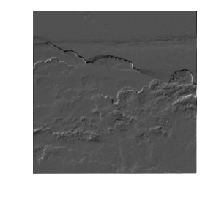

In [253]:
show_image(edge[0])

## Class Activation Maps

In [254]:
from fastai.callbacks.hooks import *

In [255]:
m = learner.model.eval();

In [256]:
print(m[0][-1])

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [257]:
preds = m(x)

In [258]:
data.classes

['cirrus', 'cumulus', 'stratus']

In [259]:
preds, yb.data

(tensor([[-2.5871,  3.7328, -1.0486]], grad_fn=<AddmmBackward>), 1)

In [337]:
def hook_backward(x,cat=yb):
    with hook_output(m[0],grad=False) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(x)
            preds[0][int(yb)].backward()
    return hook_a, hook_g, preds

In [338]:
hook_a, hook_g, preds = hook_backward(x,yb)

In [262]:
act = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

In [263]:
avg_act = act.mean(0)

In [264]:
avg_act.shape, act.shape, grad.shape

(torch.Size([7, 7]), torch.Size([512, 7, 7]), torch.Size([512, 7, 7]))

In [267]:
def cam(x_img,a):
    fig, ax = plt.subplots()
    show_image(x_img,ax)
    ax.imshow(a, cmap='magma', alpha=0.6,
              extent=(0,224,224,0),
              interpolation='bilinear')

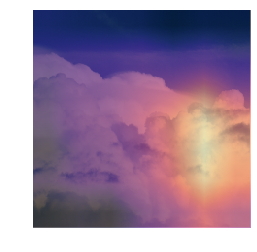

In [268]:
cam(x_img,avg_act)

## Grad-CAM

In [269]:
grad_chng = grad.mean(1).mean(1)
grad.shape, grad_chng.shape

(torch.Size([512, 7, 7]), torch.Size([512]))

In [270]:
act.shape

torch.Size([512, 7, 7])

In [271]:
grad_chng[...,None,None].shape

torch.Size([512, 1, 1])

In [272]:
back_act = act*grad_chng[...,None,None]
back_act.shape

torch.Size([512, 7, 7])

In [273]:
avg_backact = back_act.mean(0)
avg_backact.shape

torch.Size([7, 7])

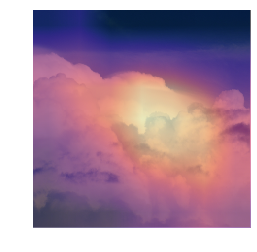

In [274]:
cam(x_img, avg_backact)

## Test Generating CAM

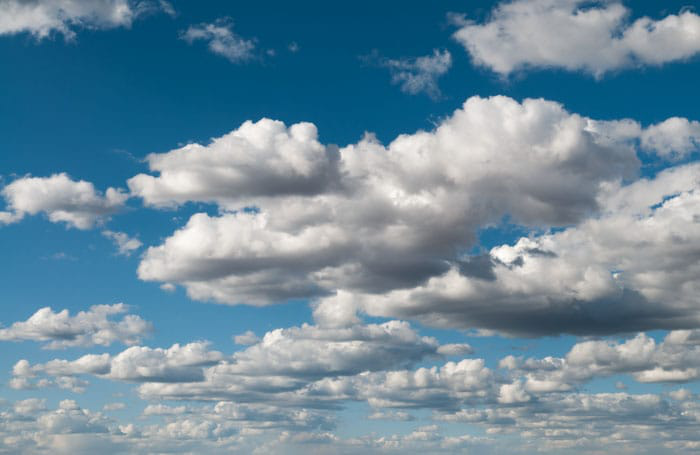

In [340]:
img = open_image(DATA/'cumulus'/'00000000.jpg')
img

In [341]:
img.shape

torch.Size([3, 455, 700])

In [342]:
xb,_ = data.one_item(img)

In [343]:
xb.shape

torch.Size([1, 3, 224, 224])

In [344]:
x_img = Image(data.denorm(xb)[0])

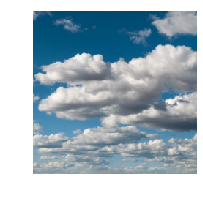

In [345]:
show_image(x_img)

In [346]:
data.classes

['cirrus', 'cumulus', 'stratus']

### For Cumulus class activations

In [348]:
hook_a, hook_g, preds = hook_backward(xb, cat=1)

In [349]:
preds

tensor([[-3.0522,  6.4014, -1.2103]], grad_fn=<AddmmBackward>)

In [350]:
acts = hook_a.stored[0]
grads = hook_g.stored[0][0]
acts.shape, grads.shape

(torch.Size([512, 7, 7]), torch.Size([512, 7, 7]))

In [351]:
avg_grads = grads.mean(1).mean(1)
backact = acts*avg_grads[...,None,None]
backact.shape

torch.Size([512, 7, 7])

In [352]:
avg_backact = backact.mean(0)
avg_backact.shape

torch.Size([7, 7])

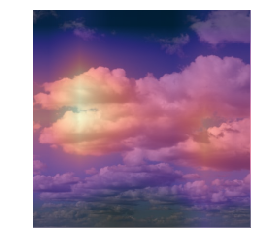

In [353]:
cam(x_img, avg_backact)

In [354]:
cum_act = avg_backact

### For Cirrus class activations

In [356]:
hook_a, hook_g, preds = hook_backward(xb, cat=0)

In [357]:
preds

tensor([[-3.0522,  6.4014, -1.2103]], grad_fn=<AddmmBackward>)

In [358]:
acts = hook_a.stored[0]
grads = hook_g.stored[0][0]
acts.shape, grads.shape

(torch.Size([512, 7, 7]), torch.Size([512, 7, 7]))

In [359]:
avg_grads = grads.mean(1).mean(1)
backact = acts*avg_grads[...,None,None]
backact.shape

torch.Size([512, 7, 7])

In [360]:
avg_backact = backact.mean(0)
avg_backact.shape

torch.Size([7, 7])

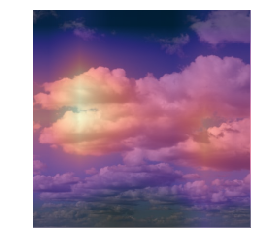

In [361]:
cam(x_img, avg_backact)

### For Stratus class activations

In [362]:
hook_a, hook_g, preds = hook_backward(xb, cat=2)
preds

tensor([[-3.0522,  6.4014, -1.2103]], grad_fn=<AddmmBackward>)

In [363]:
acts = hook_a.stored[0]
grads = hook_g.stored[0][0]
acts.shape, grads.shape

(torch.Size([512, 7, 7]), torch.Size([512, 7, 7]))

In [364]:
avg_grads = grads.mean(1).mean(1)
backact = acts*avg_grads[...,None,None]
backact.shape

torch.Size([512, 7, 7])

In [365]:
avg_backact = backact.mean(0)
avg_backact.shape

torch.Size([7, 7])

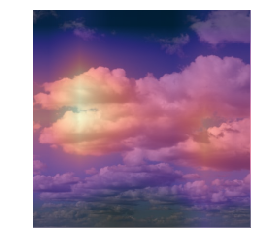

In [366]:
cam(x_img, avg_backact)

___